In [103]:
!pip install -q -r requirements.txt
import pandas as pd
import numpy as np

import datapackage
import world_bank_data as wb
import requests
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
#import tabula
#from tabula import read_pdf

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# Feature Engineering & cleaning 

## Data Loading & Cleaning

| Field      | Frequency | Source    |
| :---        |    :----:   |    :---: |
|Total Debt - gross external debt as % of GDP|	Q|	QEDS|
|Short-Term Debt - gross short-term external debt as % of GDP|	Q|	QEDS|
|Real Interest Rate - lending interest rate adjusted for inflation|	Q|	IMF - IFS|
|Foreign Exchange Reserves - total reserves (without gold) as % of GDP|	Q|	IMF - IFS|
|Trade Openness - ratio of exports plus imports to GDP|	Q|	IMF - IFS|
|Imports - imports of goods and services at current prices in USD|	Q|	IMF - IFS|
|Exports - exports of goods and services at current prices in USD|	Q|	IMF - IFS|
|Current Account - current account balance as % of GDP|	A|	See BoP from IMF Website - see 'BSA_BP6_USD'|
|Portfolio Investments - portfolio investment net at current USD|	Q|	IMF - IFS|
|FDI - net FDI inflows as % of GDP|	A|	World Bank - WDI|
|Real GDP - annual real GDP at current USD|	A|	World Bank - WDI|
|Real GDP Growth - annual growth of real GDP|A|	World Bank - WDI|
|Inflation - rate of change in CPI|A|	World Bank - WDI - TBC|
|Money Plus Quasi Money(M2) -from Monetary & Financial statistics |?|	IMF - MFS - See '35L__USD'|
|M2 Multiplier Growth - annual growth of M2|	A|	World Bank - WDI|
|M2/Reserves - ratio of M2 to foreign exchange reserves|	A|	World Bank - WDI|
|REER Overall - deviation of real effective exchange rate from 5 year rolling mean|	A|	World Bank - WDI|
|Government Spending - general government final spending as % of GDP|	A|	World Bank - WDI - Check National Sources|
|Fixed Capital Formation - gross fixed capital formation at current USD|	A|	World Bank - WDI - Check National Sources|
|Unemployment - unemployment total as % of total labor force|	A|	World Bank - TBC - check OECD|
|Contagion - event of a currency crisis in any country of the same region (t − 1)|	|	Derived|
|Soft Peg 2 - exchange rate regime applied to currency to keep its value stable against a reserve currency|	|	n/a|
|Peg 2 - exchange rate regime in which a currency’s value is fixed against either the value of another country’s currency|	|	n/a|
|Domestic Credit - ratio of domestic credit to GDP|	Q|	IMF - IFS|
|Lending Interest Rate - the bank rate meets the short- and medium-term financing needs|	Q|	IMF - IFS|
|Deposit Interest Rate - rate paid by banks for demand, time, or savings deposits|	Q|	IMF - IFS|
|Polity - combined polity score (autocracy score minus democracy score)|	|	|


### Country data 
Additional data required to join WDI & IFS data on common country code.
Data needs to be reformatted into a mapping for IFS & WEO to be joined on same country code.

In [ ]:

WOE_Dataset = pd.read_csv('IMF_country_codes.csv')
def WEO_country(WOE_Dataset):
    # Get ride of unused data
    WOE_Dataset.drop(columns= WOE_Dataset.columns[4:] , inplace=True)
    #rename columns
    old_columns = WOE_Dataset.columns
    New_columns = WOE_Dataset.iloc[0].to_list()
    rename_map = dict(zip(old_columns, New_columns))
    WOE_Dataset.rename(columns = rename_map, inplace = True)

    #Drop column 0 - the true header
    WOE_Dataset = WOE_Dataset.drop(0).copy()
    WOE_Dataset['IMF Code'] = WOE_Dataset['IMF Code'].astype(int)
    return WOE_Dataset 

In [ ]:
cntry_map = pd.read_csv('IMF_country_codes.csv')
cntry_map = WEO_country(cntry_map)

### World Bank Database
#### World Develpment Indicators (WDI) Data - The World Bank
Notes on outstanding work: 1 - Make Data DateTime Object. 2 - concat the Indicator code to the title name

#### World Development Indicators data Cleaning Function



In [ ]:
def clean_wdi_data(dataset, countries, date_from = 1980, date_to = 2002 ):
    '''
    dataset {df}: WDI Data sample
    countries {List}: List of countries to be inclided in Dataset
    date_from {int}: Lowest year - default 1980
    date_to {int}: Highest Yeat - default 2020

    Output{df}: Year, Country Name , Country Code, [Series Names]

    '''
    #Clean titles
    #Create Dictionary of column header mapping & use rename function
    old_columns = dataset.columns[4::]
    yr_columns = dataset.columns[4::].str[:4]
    yr_columns_dict = dict(zip(old_columns, yr_columns))
    dataset.rename(columns = yr_columns_dict, inplace = True)
    
    #Country Selection
    dataset = dataset[dataset['Country Name'].isin(countries)].copy()
    
    #Reform Pivotted Data
    dataset.drop([ 'Series Code'], axis=1, inplace = True)
    dataset = dataset.melt(id_vars=['Country Name','Country Code','Series Name'], var_name='Year', value_name='Value' ).copy()
    dataset = dataset.pivot(index=['Year', 'Country Name', 'Country Code'], columns='Series Name', values='Value').reset_index().copy()
    dataset.rename(columns = {'Country Code':'ISO Code'}, inplace = True)

    return dataset

In [ ]:
WOE_raw = pd.read_csv('WDI - sample.csv')

In [ ]:
#wdi_sample = pd.read_csv('WDI - sample.csv') 
#wdi_sample.head()

WOE_test = WOE_raw.copy()
WOE_cntry = ['Mexico']
WOE_test = clean_wdi_data(WOE_test, WOE_cntry, date_from = 1980, date_to = 2002 )
WOE_test.head()

Series Name,Year,Country Name,ISO Code,Broad money growth (annual %),Broad money to total reserves ratio,Gross capital formation (constant 2010 US$),Real effective exchange rate index (2010 = 100)
0,1980,Mexico,MEX,38.2095425479587,14.629444229092,166675198325.232,120.847948707833
1,1981,Mexico,MEX,50.2313331909744,17.3289922156437,192020235587.809,137.506499561169
2,1982,Mexico,MEX,54.3636880507912,32.4963549954408,145050911386.683,98.7235493103745
3,1983,Mexico,MEX,63.5052179251074,9.25319657918963,105378925920.693,86.9998506207057
4,1984,Mexico,MEX,69.1008072085602,6.69471656817234,111104213319.661,101.900803271927


### QEDS Data

Loading 'Quarterly Public Sector Debt', 'Quarterly External Debt Statistics SDDS', 'Quarterly External Debt Statistics GDDS'data using the WOE API

DP.DOD.DECN.CR.GG.Z1 = Gross PSD, General Gov., All maturities, All instruments, Domestic currency, Nominal Value, % of GDP #Quarterly Public Sector Debt

DP.DOD.DSTC.CR.GG.Z1 = Gross PSD, General Gov., Short-term, All instruments, Nominal Value, % of GDP #Quarterly Public Sector Debt

In [ ]:
Total_Debt= pd.DataFrame(wb.get_series('DP.DOD.DECN.CR.GG.Z1', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()
Shrt_Trm_Debt  = pd.DataFrame(wb.get_series('DP.DOD.DSTC.CR.GG.Z1', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()



Shrt_Trm_Debt.head()

,Country,Year,DP.DOD.DSTC.CR.GG.Z1
0,ALB,1995Q1,NaN
1,ALB,1995Q2,NaN
2,ALB,1995Q3,NaN
3,ALB,1995Q4,NaN
4,ALB,1996Q1,NaN


In [ ]:
QEDS = pd.merge(Total_Debt, Shrt_Trm_Debt, left_on=['Country', 'Year'], right_on=['Country', 'Year'], how = 'outer' )
QEDS.rename(columns = {'Country':'ISO Code',
'DP.DOD.DECN.CR.GG.Z1':'Gross PSD, General Gov., All maturities, All instruments, Domestic currency, Nominal Value, % of GDP- DP.DOD.DECN.CR.GG.Z1',
'DP.DOD.DSTC.CR.GG.Z1':'Gross PSD, General Gov., Short-term, All instruments, Nominal Value, % of GDP - DP.DOD.DSTC.CR.GG.Z1'
                        }, inplace = True)
QEDS

,ISO Code,Year,"Gross PSD, General Gov., All maturities, All instruments, Domestic currency, Nominal Value, % of GDP- DP.DOD.DECN.CR.GG.Z1","Gross PSD, General Gov., Short-term, All instruments, Nominal Value, % of GDP - DP.DOD.DSTC.CR.GG.Z1"
0,ALB,1995Q1,NaN,NaN
1,ALB,1995Q2,NaN,NaN
2,ALB,1995Q3,NaN,NaN
3,ALB,1995Q4,NaN,NaN
4,ALB,1996Q1,NaN,NaN
...,...,...,...,...
10603,URY,2019Q4,NaN,NaN
10604,URY,2020Q1,NaN,NaN
10605,URY,2020Q2,NaN,NaN
10606,URY,2020Q3,NaN,NaN


### International Financial Statistics (IFS DB) data - International Monetary Fund
Notes on outstanding work: 1 - Make Data DateTime Object. 2 - concat the Indicator code to the title name. 3 - Need to Edit the Indicators being used. 

| Field      | Indicator Code | Source    |
| :---        |    :----:   |    :---: |
| Header      | Title       | Here's this   |
| Paragraph   | Text        | And more      |

In [ ]:
def clean_IFS_data(dataset, countries, frequency, date_from, Series_Codes , date_to):
    '''
    dataset {df}: WDI Data sample
    countries {List}: List of countries to be inclided in Dataset
    date_from {int}: Lowest year - default 1980
    date_to {int}: Highest Yeat - default 2020

    Output{df}: 'Year', 'Country Name', 'Country Code', [Series Names]

    '''
    #Country Selection
    dataset = dataset[dataset['Country Name'].isin(countries)].copy()   

    #Concat Base year & Drop Base Year Column
    dataset['Indicator Name'] = np.where(dataset['Base Year'].isnull(),dataset['Indicator Name'], dataset['Indicator Name'] + " (" + dataset['Base Year'] +")").copy()
    
    # Filter by then concat the Indicator Code
    dataset = dataset[dataset['Indicator Code'].isin(Series_Codes)].copy()
    dataset['Indicator Name'] = dataset['Indicator Name'] + " - " + dataset['Indicator Code']

    dataset = dataset[dataset['Attribute']!='Status'].copy()
    
    dataset.drop(['Base Year', 'Indicator Code', 'Attribute'], axis=1, inplace = True)


    #Melt Data 
    dataset = dataset.melt(id_vars=['Country Name','Country Code','Indicator Name'], var_name='Year', value_name='Value' ).copy()

    #Frequency - Annual - Done
    if frequency == 'Y':
        non_ann = ['M', 'Q']
        dataset = dataset[~dataset.Year.str.contains('|'.join(non_ann))].copy()
    elif frequency == 'Q':
        dataset = dataset[dataset.Year.str.contains('Q')].copy()
    elif frequency == 'M':
        dataset = dataset[dataset.Year.str.contains('M')].copy()

    #Pivot Indicators to Columns
    dataset['Value'] = dataset['Value'].astype(float)
    dataset = dataset.groupby(['Year', 'Country Name', 'Country Code', 'Indicator Name']).agg({'Value':'sum'}).reset_index().copy()
    dataset = dataset.pivot(index=['Year', 'Country Name', 'Country Code'], columns='Indicator Name', values='Value').reset_index().copy()
    dataset.rename(columns = {'Country Code':'IMF Code'}, inplace = True)

    return dataset

IMF Load Function Test:

In [ ]:
# Don't run - too big!
IFS_DB =  pd.read_csv('IFS_timeSeries_1980_2020.csv')
IFS_DB.head()

KeyboardInterrupt: 

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
Countries = ['Mexico']

IMF_Indicators =['FILR_PA'
                ,'RAXGFX_USD'
                ,'NM_XDC' 
                ,'TMG_CIF_USD'
                ,'TXG_FOB_USD'
                ,'IAP_BP6_USD']
X = clean_IFS_data(IFS_DB, countries = Countries, date_from = 1980, Series_Codes = IMF_Indicators , date_to = 2002, frequency = 'Q' )
X.head(100)

Indicator Name,Year,Country Name,Country Code,"Assets, Portfolio Investment, US Dollars - IAP_BP6_USD","External Balance of Goods and Services, Imports of Goods and Services, Nominal, Domestic Currency - NM_XDC","External Trade, Goods, Value of Exports, Free on Board (FOB), US Dollars - TXG_FOB_USD","External Trade, Goods, Value of Imports, Cost, Insurance, Freight (CIF), US Dollars - TMG_CIF_USD","Financial, Interest Rates, Lending Rate, Percent per annum - FILR_PA","International Liquidity, Total Reserves excluding Gold, Foreign Exchange, US Dollars - RAXGFX_USD"
0,1980Q1,South Africa,199,0.0,0.0,6.502265e+09,3.607429e+09,9.500000,5.640000e+08
1,1980Q1,Thailand,578,0.0,0.0,1.928077e+09,2.140478e+09,16.000000,1.636000e+09
2,1980Q1,Turkey,186,0.0,0.0,7.140100e+08,1.398400e+09,NaN,9.560000e+08
3,1980Q2,South Africa,199,0.0,0.0,5.783546e+09,4.908747e+09,9.500000,6.690000e+08
4,1980Q2,Thailand,578,0.0,0.0,1.551523e+09,2.254750e+09,16.833333,2.136000e+09
...,...,...,...,...,...,...,...,...,...
95,1987Q4,Turkey,186,0.0,4905000.0,3.321600e+09,4.762600e+09,NaN,1.730000e+09
96,1988Q1,South Africa,199,0.0,0.0,5.321618e+09,4.508897e+09,13.333333,4.730000e+08
97,1988Q1,Thailand,578,0.0,0.0,3.507266e+09,4.705675e+09,11.500000,4.419000e+09
98,1988Q1,Turkey,186,0.0,4450000.0,2.802400e+09,3.492700e+09,NaN,1.663000e+09


Useful code to find data type for each value in the dataframe

### Upsampling Annualised data

In [ ]:

Resample = pd.DataFrame({'Period':pd.Series(pd.date_range(start ='1980', end = '2020', freq="Q")).dt.to_period('Q')})
Resample.head()

,Period
0,1980Q1
1,1980Q2
2,1980Q3
3,1980Q4
4,1981Q1


In [ ]:
Resample['Year'] =Resample['Period'].dt.year
Resample.head()

,Period,Year
0,1980Q1,1980
1,1980Q2,1980
2,1980Q3,1980
3,1980Q4,1980
4,1981Q1,1981


Resample using the pythonic resample method

In [ ]:
HUN = WOE_test[WOE_test['ISO Code']=='HUN'].copy()
HUN['Year'] = pd.to_datetime(HUN.Year)#.dt.year
HUN.drop(columns = ['Country Name', 'ISO Code'], inplace=True, axis = 1)
HUN.head(10)

Series Name,Year,Broad money growth (annual %),Broad money to total reserves ratio,Gross capital formation (constant 2010 US$),Real effective exchange rate index (2010 = 100)
0,1980-01-01,..,..,..,..
2,1981-01-01,..,..,..,..
4,1982-01-01,..,..,..,..
6,1983-01-01,2.28284278535535,5.51699493635597,..,..
8,1984-01-01,5.10247052217855,4.25815773895428,..,..
10,1985-01-01,10.9159710628826,3.41163289220185,..,..
12,1986-01-01,8.76999337735054,3.67354077289799,..,..
14,1987-01-01,9.6440893743427,5.20919175776884,..,..
16,1988-01-01,2.19264295089691,5.68005233145182,..,..
18,1989-01-01,16.5329578949102,6.48933685941606,..,..


In [ ]:
HUN.set_index(['Year'],inplace=True)
#HUN = np.where(HUN == "..", np.NaN,HUN).copy()
HUN.replace("..",np.NaN, inplace=True)
HUN= HUN.astype(float)
HUN.head(5)

Series Name,Broad money growth (annual %),Broad money to total reserves ratio,Gross capital formation (constant 2010 US$),Real effective exchange rate index (2010 = 100)
Year,,,,
1980-01-01,NaN,NaN,NaN,NaN
1981-01-01,NaN,NaN,NaN,NaN
1982-01-01,NaN,NaN,NaN,NaN
1983-01-01,2.282843,5.516995,NaN,NaN
1984-01-01,5.102471,4.258158,NaN,NaN


In [ ]:
Qrt = HUN.resample('Q' ).bfill()
Qrt.tail(10)

Series Name,Broad money growth (annual %),Broad money to total reserves ratio,Gross capital formation (constant 2010 US$),Real effective exchange rate index (2010 = 100)
Year,,,,
2017-12-31,11.815750,3.023984,3.649924e+10,90.144429
2018-03-31,8.149967,2.995998,4.029662e+10,88.915411
2018-06-30,8.149967,2.995998,4.029662e+10,88.915411
2018-09-30,8.149967,2.995998,4.029662e+10,88.915411
2018-12-31,8.149967,2.995998,4.029662e+10,88.915411
2019-03-31,20.894073,NaN,NaN,85.456919
2019-06-30,20.894073,NaN,NaN,85.456919
2019-09-30,20.894073,NaN,NaN,85.456919
2019-12-31,20.894073,NaN,NaN,85.456919


In [ ]:
Qrt2 = HUN.resample('Q' ).mean()
Qrt2.tail(10)

Series Name,Broad money growth (annual %),Broad money to total reserves ratio,Gross capital formation (constant 2010 US$),Real effective exchange rate index (2010 = 100)
Year,,,,
2017-12-31,NaN,NaN,NaN,NaN
2018-03-31,11.815750,3.023984,3.649924e+10,90.144429
2018-06-30,NaN,NaN,NaN,NaN
2018-09-30,NaN,NaN,NaN,NaN
2018-12-31,NaN,NaN,NaN,NaN
2019-03-31,8.149967,2.995998,4.029662e+10,88.915411
2019-06-30,NaN,NaN,NaN,NaN
2019-09-30,NaN,NaN,NaN,NaN
2019-12-31,NaN,NaN,NaN,NaN


### Creating Full Dataset

Enriching IMF & WEO Data with the correct Country Code to allow for joinging

In [ ]:
cntry_map = pd.read_csv('IMF_country_codes.csv')
cntry_map = WEO_country(cntry_map)
cntry_map = cntry_map.iloc[:,0:2].copy()

In [ ]:
test_IFS = pd.read_csv('IFS sample.csv')

In [ ]:
cntrys = ['Afghanistan, Islamic Rep. of', 'Angola']
required_indicators = ['HPHSPA_PA']
test_IFS = clean_IFS_data(test_IFS, countries = cntrys, date_from = 1980, Series_Codes = required_indicators , date_to = 2002, frequency = 'Q' )
test_IFS.head()

Indicator Name,Year,Country Name,IMF Code,"Fund Accounts, SDR Holdings as % of Allocation, Percent per annum - HPHSPA_PA"
0,1920Q1,Angola,614,0.0
1,1920Q2,Angola,614,0.0
2,1920Q3,Angola,614,0.0
3,1920Q4,Angola,614,0.0
4,1921Q1,Angola,614,0.0


In [ ]:
Full_data = pd.merge(test_IFS, cntry_map, left_on='IMF Code', right_on='IMF Code', how = 'left' ).head()
iso = Full_data["ISO Code"]
Full_data.drop("ISO Code",axis=1, inplace=True)
Full_data.insert(2, "ISO Code", iso)
Full_data

,Year,Country Name,ISO Code,IMF Code,"Fund Accounts, SDR Holdings as % of Allocation, Percent per annum - HPHSPA_PA"
0,1920Q1,Angola,AGO,614,0.0
1,1920Q2,Angola,AGO,614,0.0
2,1920Q3,Angola,AGO,614,0.0
3,1920Q4,Angola,AGO,614,0.0
4,1921Q1,Angola,AGO,614,0.0


In [ ]:
#test_IFS['Year'].apply(lambda x: type(x).__name__)
#test_IFS['Year'].to_period("Q")
#pd.to_datetime(df.date).dt.to_period('Q')
dt_test = test_IFS.copy()
dt_test.Year = pd.to_datetime(dt_test.Year).dt.to_period('Q')
#dt_test.set_index(pd.to_datetime(dt_test.Year).dt.to_period('Q'))
dt_test

Indicator Name,Year,Country Name,IMF Code,"Fund Accounts, SDR Holdings as % of Allocation, Percent per annum - HPHSPA_PA"
0,1920Q1,Angola,614,0.000000
1,1920Q2,Angola,614,0.000000
2,1920Q3,Angola,614,0.000000
3,1920Q4,Angola,614,0.000000
4,1921Q1,Angola,614,0.000000
...,...,...,...,...
401,2020Q2,Angola,614,73.423235
402,2020Q3,Angola,614,71.369189
403,2020Q4,Angola,614,68.548730
404,2021Q1,Angola,614,65.359215


#### IFS & QEDS Data Join

In [ ]:
Full_data = pd.merge(Full_data, QEDS, left_on=['Year','ISO Code'], right_on=['Year','ISO Code'], how = 'left' ).copy()

#### Converting WOE Data into Quarterly Periods

In [ ]:
pd.DataFrame([1, 2], index=pd.period_range('2012-01-01',
                                            freq='Q',
                                            periods=2)).reset_index()

,index,0
0,2012Q1,1
1,2012Q2,2


In [ ]:
WOE_raw
old_columns = WOE_raw.columns[4::]
yr_columns = WOE_raw.columns[4::].str[:4]
yr_columns_dict = dict(zip(old_columns, yr_columns))
WOE_raw.rename(columns = yr_columns_dict, inplace = True)
WOE_raw

,Country Name,Country Code,Series Name,Series Code,2020,2019,2018,2017,2016,2015,...,1989,1988,1987,1986,1985,1984,1983,1982,1981,1980
0,Afghanistan,AFG,Gross capital formation (constant 2010 US$),NE.GDI.TOTL.KD,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
1,Afghanistan,AFG,Broad money growth (annual %),FM.LBL.BMNY.ZG,12.0637466878922,5.70436037333889,2.57415378471386,4.09327496841465,9.72542825974532,3.07902196833481,...,37.1566475203784,34.5308326648949,50.6904779154956,12.3295614503191,10.409507083737,..,..,17.9587060101981,17.4498215541832,16.8532923185537
2,Afghanistan,AFG,Broad money to total reserves ratio,FM.LBL.BMNY.IR.ZS,..,0.793632803684602,0.818710390530765,0.859016751556685,0.921010226887482,0.968056185943023,...,8.85143009236444,6.19464026378841,4.05085192662084,3.15793383344012,2.92629527839025,3.07622789051786,..,1.81620389187557,1.67147204172895,1.11793377526649
3,Afghanistan,AFG,Real effective exchange rate index (2010 = 100),PX.REX.REER,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Albania,ALB,Gross capital formation (constant 2010 US$),NE.GDI.TOTL.KD,..,..,3595178603.90026,3546485505.11994,3397385139.22416,3385214269.83924,...,..,..,..,..,..,..,..,..,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1059,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
Y2020 = WOE_raw.iloc[:,0:5]
Y2020['2020'] = np.where(Y2020['2020'] == "..", np.NaN,Y2020['2020'])
Y2020['2020'] = Y2020['2020'].astype(float)
Y2020[Y2020['Country Name']=='Argentina']

In [ ]:
WOE_testA =  WOE_test.set_index(['Year']).copy()
WOE_testA

Series Name,Country Name,ISO Code,Broad money growth (annual %),Broad money to total reserves ratio,Gross capital formation (constant 2010 US$),Real effective exchange rate index (2010 = 100)
Year,,,,,,
1980,Hungary,HUN,..,..,..,..
1980,South Africa,ZAF,22.8507513885544,5.47953147000172,41470623355.0728,165.188043881133
1981,Hungary,HUN,..,..,..,..
1981,South Africa,ZAF,17.2048728177921,10.3143593733789,45629364093.4814,173.965017856705
1982,Hungary,HUN,..,..,..,..
...,...,...,...,...,...,...
2018,South Africa,ZAF,5.59961566272095,5.1900974194881,82523869140.9586,80.7144353745103
2019,Hungary,HUN,8.14996704366379,2.99599793288861,40296620964.5962,88.9154112185394
2019,South Africa,ZAF,6.11024523226612,4.73151814615898,81243117953.9007,78.1427521961595


In [ ]:
#WOE_test.Year = pd.to_datetime(WOE_test.Year).dt.to_period('Y')

#WOE_testQ = WOE_test.set_index(['Year', 'ISO Code']).copy()

WOE_testA.resample('Q', convention='start').asfreq()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
WOE_test.head()

Series Name,Year,Country Name,ISO Code,Broad money growth (annual %),Broad money to total reserves ratio,Gross capital formation (constant 2010 US$),Real effective exchange rate index (2010 = 100)
0,1980,Hungary,HUN,..,..,..,..
1,1980,South Africa,ZAF,22.8507513885544,5.47953147000172,41470623355.0728,165.188043881133
2,1981,Hungary,HUN,..,..,..,..
3,1981,South Africa,ZAF,17.2048728177921,10.3143593733789,45629364093.4814,173.965017856705
4,1982,Hungary,HUN,..,..,..,..


## Classification

IMF-IFS: Exchange Rates, Domestic Currency per U.S. Dollar, Period Average, Rate - ENDA_XDC_USD_RATE

IMF-IFS: Exchange Rates, US Dollar per Domestic Currency, End of Period - EDNE_USD_XDC_RATE

IMF-IFS: Financial, Interest Rates, Monetary Policy-Related Interest Rate, Percent per annum - FPOLM_PA

        Money Market Rate - FIMM_PA
crash definition: 

$$
\begin{aligned}


&=  100[\frac{(e_{t+\Delta} - e_{t})}{e_{t}}][\frac{1+r^*_{t}}{1+r_{t}}] > \gamma \\
\end{aligned}
$$
where

$e_{t}$ = Domestic currency to exchange rate at t

$e_{t+\Delta}$ = Domestic currency to exchange rate at previous time period (Quarter/Year/Month)

$r_{t}$ = US Short term policy rate 

$r^*_{t}$ = Domestic Short term policy rate 

$\gamma$ =Tollerance  




### Using IMF API 

Generic Call to take 1 field from the IMF Databases

In [51]:
def Call_IMF(DB,freq,Country_iso2, start, finish, Indicator_code):
    core = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/'
    key = f'{DB}/{freq}.{Country_iso2}.{Indicator_code}'
    time = f'.?startPeriod={start}&endPeriod={finish}'
    url = f'{core}{key}{time}'

    # Get data from the above URL using the requests package
    data = requests.get(url).json()

    # Load data into a pandas dataframe
    series = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
    series['@OBS_VALUE'] = series['@OBS_VALUE'].astype(float).copy()
    series.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':Indicator_code}, inplace = True)
    return series

In [55]:
#test
mex = Call_IMF('IFS',freq='A',Country_iso2='MX', start='1980', finish='2020', Indicator_code='FPOLM_PA')
mex
#iso2 = 'MX'
#mex.rename(columns = {'FPOLM_PA':f'{iso2} Money Market Rate -  ENDA_XDC_USD_RATE'}, inplace = True)
#US = Call_IMF('IFS',freq='Q',Country_iso2='US', start='1980', finish='2020', Indicator_code='FPOLM_PA')

,Year,FPOLM_PA
0,2002,8.25
1,2003,6.12
2,2004,8.75
3,2005,8.27
4,2006,7.02
5,2007,7.57
6,2008,8.25
7,2009,4.50
8,2010,4.50
9,2011,4.50


In [ ]:
mex.rename(columns = { mex.columns[1]  :'testing!!'}, inplace = True)
mex.head()

,Year,testing!!
0,1980-Q1,0.0228253666656667
1,1980-Q2,0.0228477333323333
2,1980-Q3,0.022997399999
3,1980-Q4,0.0231335333323333
4,1981-Q1,0.023489499999


Function to call IMF Data for Short term policy rate (Money Market rate) & Exchange Rates

In [109]:
def Get_crash_data(iso2, srt, fin, term):
    #Money Market Rate
    if term == 'MMK': 
        indicator = 'FPOLM_PA'
        rate = 'Money Market Rate'
    #Treasury Bill Rate
    elif term == 'TB': 
        indicator = 'FITB_PA'
        rate = 'Treasury Bill Rate'
    # Central Bank Policy Rate
    elif term == 'central':
        indicator = 'FPOLM_PA'    
        rate = 'Central Bank Policy Rate'

    Domestic = Call_IMF('IFS',freq='Q',Country_iso2= iso2, start=srt, finish=fin, Indicator_code=indicator)
    Domestic.rename(columns = { Domestic.columns[1]  :f'{iso2} - {rate} - {indicator}'}, inplace = True)


    US = Call_IMF('IFS',freq='Q',Country_iso2='US', start=srt, finish=fin, Indicator_code= indicator)
    US.rename(columns = { US.columns[1]  :f'USA - {rate} - {indicator}'}, inplace = True)
    
    Dataset = pd.merge(US, Domestic, left_on=['Year'], right_on=['Year'], how = 'left' ).copy()
    

    FX = Call_IMF('IFS',freq='Q',Country_iso2= iso2, start=srt, finish=fin, Indicator_code='ENDA_XDC_USD_RATE')
    FX.rename(columns = {'ENDA_XDC_USD_RATE':f'{iso2} - Exchange Rates, Domestic Currency per U.S. Dollar, Period Average, Rate - ENDA_XDC_USD_RATE'}, inplace = True)
    
    Dataset = pd.merge(Dataset, FX, left_on=['Year'], right_on=['Year'], how = 'left' ).copy()
    #Dataset.Year = pd.to_datetime(Dataset.Year).dt.to_period('Q')

    #  Create Classification
    Dataset['% Diff'] = Dataset.iloc[:,[3]].pct_change().copy()
    Dataset['Dom_rate'] = (1+(Dataset.iloc[:,[1]]/100))
    Dataset['US_rate'] = (1+(Dataset.iloc[:,[2]]/100))

    Dataset['rate ratio'] =  Dataset['Dom_rate']/Dataset['US_rate'] 
    Dataset['gamma'] = 100 * Dataset['% Diff'] * Dataset['rate ratio']

    cut_labels = ['Green', 'Yellow', 'Orange', 'Red']
    cuts = [-50,5,7.5,10,15]
    Dataset['quantiles'] = pd.cut(Dataset['gamma'],
                              bins=cuts,
                              labels=cut_labels)

    return Dataset

In [110]:
x = Get_crash_data('TR','1980', '2020', term='central')

In [100]:
x['gamma'].describe()

count    139.000000
mean       5.118569
std        7.549535
min       -7.421610
25%        0.803160
50%        4.954610
75%        8.443242
max       57.026283
Name: gamma, dtype: float64

In [111]:
x

,Year,USA - Central Bank Policy Rate - FPOLM_PA,TR - Central Bank Policy Rate - FPOLM_PA,"TR - Exchange Rates, Domestic Currency per U.S. Dollar, Period Average, Rate - ENDA_XDC_USD_RATE",@OBS_STATUS,% Diff,Dom_rate,US_rate,rate ratio,gamma,quantiles
0,1982-Q4,8.500,NaN,0.000183,NaN,NaN,1.08500,NaN,NaN,NaN,NaN
1,1983-Q1,8.630,NaN,0.000194,NaN,0.061854,1.08630,NaN,NaN,NaN,NaN
2,1983-Q2,9.000,NaN,0.000212,NaN,0.092670,1.09000,NaN,NaN,NaN,NaN
3,1983-Q3,9.380,NaN,0.000235,NaN,0.107814,1.09380,NaN,NaN,NaN,NaN
4,1983-Q4,9.380,NaN,0.000261,NaN,0.108456,1.09380,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
148,2019-Q4,1.625,10.50,5.786590,NaN,0.021073,1.01625,1.1050,0.919683,1.938034,Green
149,2020-Q1,0.125,8.25,6.096558,NaN,0.053567,1.00125,1.0825,0.924942,4.954610,Green
150,2020-Q2,0.125,6.75,6.859544,NaN,0.125150,1.00125,1.0675,0.937939,11.738331,Red
151,2020-Q3,0.125,8.75,7.200925,NaN,0.049767,1.00125,1.0875,0.920690,4.582017,Green


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


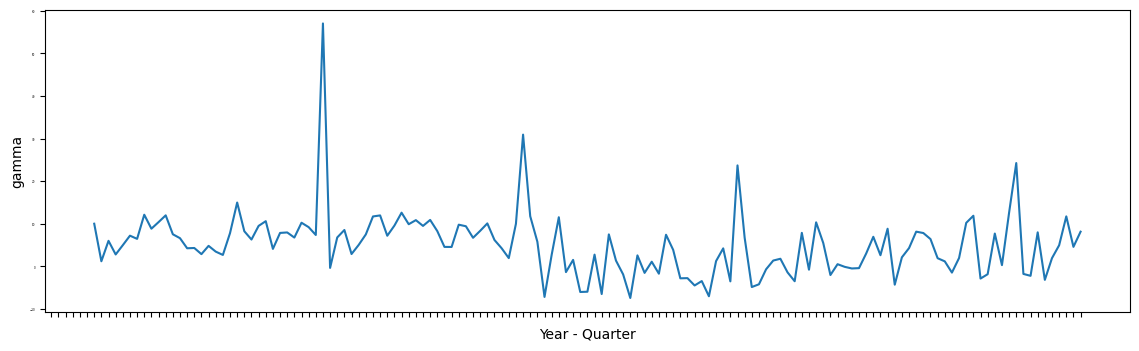

In [117]:


fig, ax = plt.subplots(dpi=100,figsize=(14, 4))
sns.lineplot(data = x, x = 'Year',y ='gamma')

#sns.barplot(x ='arrival_date_month', y = 'adults',hue = "is_canceled", data = d)
#sns.barplot(x ='arrival_date_month', y = 'is_canceled',hue = 'hotel', data = months_cancel , )

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tick_params(axis='both', which='major', labelsize=2)
plt.xlabel('Year - Quarter', fontsize=10)
plt.show()

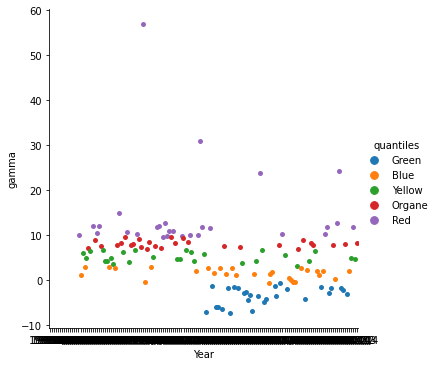

In [94]:
sns.catplot(data = x, x = 'Year',y ='gamma',hue ='quantiles' )

## World Bank API 

In [ ]:
import pandas as pd
import world_bank_data as wb
pd.set_option('display.max_rows', 6)

In [ ]:
wb.get_topics()

In [ ]:
pd.DataFrame(wb.get_series('DP.DOD.DECN.CR.GG.Z1', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()

,Country,Year,DP.DOD.DECN.CR.GG.Z1
0,ALB,1995Q1,NaN
1,ALB,1995Q2,NaN
2,ALB,1995Q3,NaN
...,...,...,...
10605,URY,2020Q2,NaN
10606,URY,2020Q3,NaN
10607,URY,2020Q4,NaN


In [ ]:
pd.DataFrame(wb.get_series('BX.KLT.DINV.WD.GD.ZS', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index() #= Current accounts



,Country,Year,BX.KLT.DINV.WD.GD.ZS
0,ARB,1980,-0.493255
1,ARB,1981,1.779518
2,ARB,1982,2.945949
3,ARB,1983,1.534027
4,ARB,1984,1.588909
...,...,...,...
10819,ZWE,2016,1.669274
10820,ZWE,2017,1.121496
10821,ZWE,2018,3.062893
10822,ZWE,2019,1.305924


In [ ]:

'''
Annual Fields
M2_Multiplier_Growth = pd.DataFrame(wb.get_series('FM.LBL.BMNY.ZG', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()
M2_by_Reserves = pd.DataFrame(wb.get_series('FM.LBL.BMNY.IR.ZS', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()
REED = pd.DataFrame(wb.get_series('PX.REX.REER', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()
Fixed_Capital_Formation = pd.DataFrame(wb.get_series('NE.GDI.FTOT.CD', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()
Current Account = pd.DataFrame(wb.get_series('BN.CAB.XOKA.GD.ZS', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()


Quarterly Fields
DT.DOD.PUBS.ST.AR.US = Public Sector Ext. Debt Pos., Short-term, All instruments, USD
DT.DOD.DECT.CD.ST.US = Gross Ext. Debt Pos., All Sectors, Short-term, All instruments, USD
DP.DOD.DSTC.CR.GG.Z1 = Gross PSD, General Gov., Short-term, All instruments, Nominal Value, % of GDP #Quarterly Public Sector Debt



DT.DOD.DECT.CD.LT.US = Gross Ext. Debt Pos., All Sectors, Long-term, All instruments, USD
DP.DOD.DECN.CR.GG.Z1 = Gross PSD, General Gov., All maturities, All instruments, Domestic currency, Nominal Value, % of GDP #Quarterly Public Sector Debt

'''

,Country,Year,FM.LBL.BMNY.ZG
0,ARB,1980,NaN
1,ARB,1981,NaN
2,ARB,1982,NaN
...,...,...,...
10821,ZWE,2018,28.048464
10822,ZWE,2019,249.835278
10823,ZWE,2020,NaN


### Search Indicators

In [ ]:
srt = wb.search_indicators('exchange rate')
srt[srt['source'].isin(['Quarterly Public Sector Debt',
                        'Quarterly External Debt Statistics SDDS',
                        'Quarterly External Debt Statistics GDDS'#,  'World Development Indicators'  
                     ])]

#srt['source'].unique()



,name,unit,source,sourceNote,sourceOrganization,topics
id,,,,,,
DT.DOD.DECT.CD.AR.EX.US,"Gross Ext. Debt Pos., All Sectors, All maturit...",,Quarterly External Debt Statistics SDDS,,,
DT.DOD.DECT.CD.CB.AR.EX.US,"Gross Ext. Debt Pos., Deposit-Taking Corp., ex...",,Quarterly External Debt Statistics SDDS,,,
DT.DOD.DECT.CD.GG.AR.EX.US,"Gross Ext. Debt Pos., General Government, All ...",,Quarterly External Debt Statistics SDDS,,,
DT.DOD.DECT.CD.IL.AR.EX.US,"Gross Ext. Debt Pos., DI: Intercom Lending, Al...",,Quarterly External Debt Statistics SDDS,,,
DT.DOD.DECT.CD.MA.AR.EX.US,"Gross Ext. Debt Pos., Central Bank, All maturi...",,Quarterly External Debt Statistics SDDS,,,
DT.DOD.DECT.CD.OT.AR.EX.US,"Gross Ext. Debt Pos., Other Sectors, All matur...",,Quarterly External Debt Statistics SDDS,,,
DT.DOD.DIDI.CD.IL.EX.US,"Gross Ext. Debt Pos., DI: Intercom Lending, Al...",,Quarterly External Debt Statistics SDDS,,,
DT.DOD.DIFE.CD.IL.EX.US,"Gross Ext. Debt Pos., DI: Intercom Lending, Al...",,Quarterly External Debt Statistics SDDS,,,
DT.DOD.DIIE.CD.IL.EX.US,"Gross Ext. Debt Pos., DI: Intercom Lending, Al...",,Quarterly External Debt Statistics SDDS,,,


### Search Countries

In [10]:
#wb.get_sources() #  All Database sources 
WB_countries = wb.get_countries().reset_index()


In [11]:
WB_countries.query("name == 'Turkey'")


,id,iso2Code,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude
275,TUR,TR,Turkey,Europe & Central Asia,Europe & Central Asia (excluding high income),Upper middle income,IBRD,Ankara,32.3606,39.7153


'''
'World Development Indicators'    
'Quarterly Public Sector Debt',
'Quarterly External Debt Statistics SDDS',
'Quarterly External Debt Statistics GDDS',
'''
UPP.COM.POL.XQ -Combined polity score

## IMF API

In [ ]:
def Call_IMF(DB,freq,Country_iso2, start, finish, Indicator_code):
    core = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/'
    key = f'{DB}/{freq}.{Country_iso2}.{Indicator_code}'
    time = f'.?startPeriod={start}&endPeriod={finish}'
    url = f'{core}{key}{time}'

    # Get data from the above URL using the requests package
    data = requests.get(url).json()

    # Load data into a pandas dataframe
    series = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
    series.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':Indicator_code}, inplace = True)
    return series


In [ ]:
Call_IMF('IFS',freq='Q',Country_iso2='MX', start='1980', finish='2020', Indicator_code='FPOLM_PA')

In [ ]:
import requests
import pandas as pd

# URL for the IMF JSON Restful Web Service, 
# IFS database, and Australian export prices series
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS'

# Get data from the above URL using the requests package
XXX = requests.get(url).json()

# Load data into a pandas dataframe
XXX

'"Error":{"status":413,"message":"Response size exceeds service limit","more_info":"The query results in more than the supported maximum number of time series in one request. Please change your query. http://datahelp.imf.org/knowledgebase/articles/937155-how-to-query-large-datasets-with-data-services"}'

In [ ]:
# Import libraries
import requests
import pandas as pd

# URL for the IMF JSON Restful Web Service, 
# IFS database, and Australian export prices series
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/Q.AU.FIMM_PA.?startPeriod=1957&endPeriod=2016'
cpi = 'http://dataservices.imf.org/REST/SDMX_XML.svc/CompactData/IFS/M..PCPI_IX.?startPeriod=2000&endPeriod=2001'
#Thiland = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/Q.TH.NX_SA_XDC.?startPeriod=1980&endPeriod=2020'
# Get data from the above URL using the requests package
data = requests.get(url).json()

# Load data into a pandas dataframe
auxp = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])

# Show the last five observiations
auxp.tail(100)

,@TIME_PERIOD,@OBS_VALUE
63,1992-Q1,7.60193867243867
64,1992-Q2,6.92198412698413
65,1992-Q3,5.8457205596336
66,1992-Q4,5.76779220779221
67,1993-Q1,5.70205072463768
...,...,...
158,2015-Q4,2
159,2016-Q1,2
160,2016-Q2,1.84
161,2016-Q3,1.59


In [ ]:
pd.DataFrame(data['CompactData']['DataSet']['Series'])

,@FREQ,@REF_AREA,@INDICATOR,@UNIT_MULT,@TIME_FORMAT,Obs
0,Q,AU,FIMM_PA,0,P3M,"{'@TIME_PERIOD': '1976-Q2', '@OBS_VALUE': '7.8..."
1,Q,AU,FIMM_PA,0,P3M,"{'@TIME_PERIOD': '1976-Q3', '@OBS_VALUE': '7.5..."
2,Q,AU,FIMM_PA,0,P3M,"{'@TIME_PERIOD': '1976-Q4', '@OBS_VALUE': '6.9..."
3,Q,AU,FIMM_PA,0,P3M,"{'@TIME_PERIOD': '1977-Q1', '@OBS_VALUE': '7.4..."
4,Q,AU,FIMM_PA,0,P3M,"{'@TIME_PERIOD': '1977-Q2', '@OBS_VALUE': '8.5..."
...,...,...,...,...,...,...
158,Q,AU,FIMM_PA,0,P3M,"{'@TIME_PERIOD': '2015-Q4', '@OBS_VALUE': '2'}"
159,Q,AU,FIMM_PA,0,P3M,"{'@TIME_PERIOD': '2016-Q1', '@OBS_VALUE': '2'}"
160,Q,AU,FIMM_PA,0,P3M,"{'@TIME_PERIOD': '2016-Q2', '@OBS_VALUE': '1.84'}"
161,Q,AU,FIMM_PA,0,P3M,"{'@TIME_PERIOD': '2016-Q3', '@OBS_VALUE': '1.59'}"


In [ ]:
# Import libraries
import requests
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
key = 'CompactData/IFS/M.GB+UK.PMP_IX' # adjust codes here

# Navigate to series in API-returned JSON data
data = requests.get(f'{url}{key}').json()['CompactData']['DataSet']['Series']

print(data['Obs'])

SyntaxError: invalid syntax (<ipython-input-39-31cd623e8f63>, line 7)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5afecb5f-7d28-4b37-ae51-8d94c0fa9663' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>